## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [7]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/planet/models', exist_ok=True)
os.makedirs('/cache/planet/tmp', exist_ok=True)

!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
!ln -s /cache/planet/tmp {PATH}

PermissionError: [Errno 13] Permission denied: '/cache'

In [4]:
ls {PATH}

models/    test-jpg.tar     tmp/        train-jpg.tar     train_v2.csv
test-jpg/  test-jpg.tar.7z  train-jpg/  train-jpg.tar.7z


## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

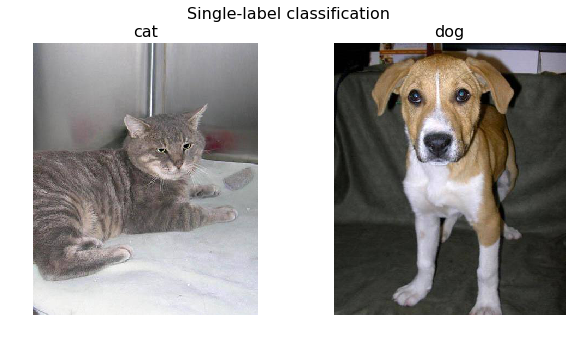

In [7]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

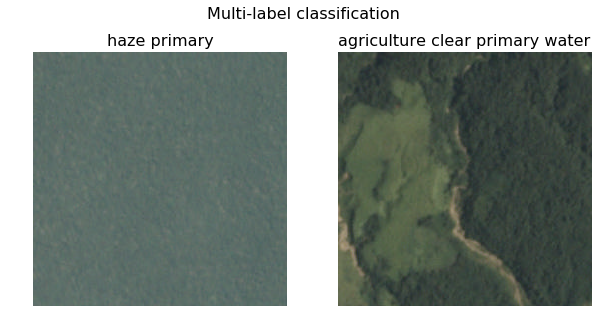

In [8]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [9]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [10]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [11]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [12]:
data = get_data(256)

In [13]:
x,y = next(iter(data.val_dl))

In [14]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [15]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

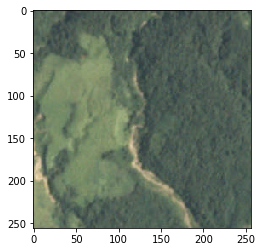

In [16]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [17]:
sz=64

In [18]:
data = get_data(sz)

In [19]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [22]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.215    0.26606  0.81116]                        



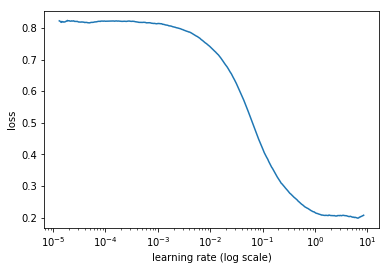

In [25]:
lrf=learn.lr_find()
learn.sched.plot()

In [25]:
lr = 0.2

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.14401  0.13486  0.88004]                        
[ 1.       0.14211  0.12953  0.88446]                        
[ 2.       0.13588  0.1282   0.88718]                        
[ 3.       0.13573  0.1281   0.88748]                        
[ 4.       0.13076  0.12599  0.8893 ]                        
[ 5.       0.1328   0.12431  0.89085]                        
[ 6.       0.13065  0.12407  0.89116]                        



In [29]:
lrs = np.array([lr/9,lr/3,lr])

In [29]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.12273  0.1118   0.90382]                        
[ 1.       0.11435  0.11021  0.90431]                        
[ 2.       0.10996  0.10612  0.90816]                        
[ 3.       0.11176  0.10554  0.90926]                        
[ 4.       0.10457  0.10354  0.91175]                        
[ 5.       0.09892  0.10198  0.91299]                         
[ 6.       0.09778  0.10118  0.91244]                         



In [30]:
learn.save(f'{sz}')

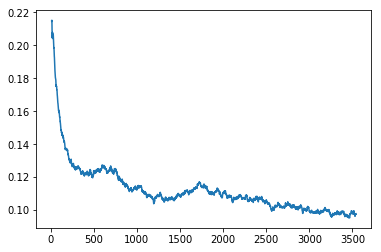

In [31]:
learn.sched.plot_loss()

In [26]:
sz=128

In [27]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.13327  0.12141  0.8951 ]                        
[ 1.       0.13038  0.11653  0.89889]                        
[ 2.       0.1254   0.11461  0.90077]                        
[ 3.       0.12601  0.11486  0.90076]                        
[ 4.       0.12231  0.11181  0.90304]                        
[ 5.       0.12048  0.11016  0.90584]                        
[ 6.       0.119    0.11014  0.90519]                        



In [30]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.10502  0.09667  0.91921]                        
[ 1.       0.09832  0.09509  0.91832]                         
[ 2.       0.09298  0.0914   0.92219]                         
[ 3.       0.09671  0.09319  0.91971]                         
[ 4.       0.09244  0.0906   0.92221]                         
[ 5.       0.08811  0.08825  0.92574]                         
[ 6.       0.08599  0.08842  0.92404]                         



In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [26]:
tta = learn.TTA()

In [27]:
f2(*tta)

0.93626519738612801

### End